# NOTE BOOK FOR DEVELOPING THE RSI STRATEGY 

## AIM TO HAVE FULL FUNCTIONALITY SIMILAR TO SMA STRATEGY


In [259]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# HOW DOES CHANGING THE PARAMETERS ALLOW TO FIT DIFFERENT TRADING STYLES OR RISK:REWARD RATIOS?

PERIOD CHANGING:
- SHORTER = more sensitive to price changes --> more signals | best suited for faster trades maybe scalps?
- DEFAULT (14) = Balanced and works well for most cases | suited standard swing traders or mid term strategies
- LONGER (21, 30,...) = Smooths out signals --> fewer trades possibly better filtered | suited for conservative long term traders who want A setups (ideally every trade is A setup)

TAKE PROFIT AND STOP LOSS ADJUSTMENTS
- LOW VALUE = 
    - TP: quick exits with lower profit per trade
    - SL: tighter control, small losses --> avoiding large drawdowns could be easier
- HIGH VALUE =
    - TP: allows trades to breathe --> potentially higher gains
    - SL: can avoid getting stopped out too early but at the risk of bigger losses

COMMON TAKE PROFIT RANGE --> 5 - 15%

COMMON STOP LOSS RANGE --> 2 - 10%

In [260]:
#Strategy Parameters
ticker = "NVDA"
rsi_period = 14
rsi_overbought = 60
rsi_oversold = 40
take_profit_pct = 0.55
stop_loss_pct = 0.10
years = 5
initial_capital = 1



In [261]:
end_date = datetime.today()
start_date = end_date - timedelta(days = years * 365)

df_rsi_v1 = yf.download(ticker, start=start_date, end=end_date)

df_rsi_v1.columns = df_rsi_v1.columns.get_level_values(0)

C:\Users\nic\AppData\Local\Temp\ipykernel_7304\867439909.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_rsi_v1 = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [262]:
#compute RSI 
def compute_rsi(series, period = 14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window = period).mean()
    avg_loss = loss.rolling(window = period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_rsi_v1['RSI'] = compute_rsi(df_rsi_v1['Close'],rsi_period)


In [263]:
#defining TP/SL logic similar to SMA 
tp_sl_signals = []
in_trade = False
entry_price = 0

for i in range(len(df_rsi_v1)):
    close_price = df_rsi_v1['Close'].iloc[i]
    rsi_value = df_rsi_v1['RSI'].iloc[i]

    if not in_trade:
        if rsi_value < rsi_oversold:
            entry_price = close_price
            in_trade = True
            tp_sl_signals.append(1)
        else:
            tp_sl_signals.append(0)
    else:
        current_return = (close_price - entry_price) / entry_price
        exit_signal = rsi_value > rsi_overbought

        if current_return >= take_profit_pct or current_return <= -stop_loss_pct or exit_signal:
            in_trade = False
            tp_sl_signals.append(0)
        else:
            tp_sl_signals.append(1)

df_rsi_v1['TP_SL_Signal'] = tp_sl_signals
        
    

In [264]:
#calculating return
df_rsi_v1['Market Return'] = df_rsi_v1['Close'].pct_change()
df_rsi_v1['Strategy Return'] = df_rsi_v1['Market Return'] * df_rsi_v1['TP_SL_Signal'].shift(1).fillna(0)

df_rsi_v1['Cumulative Market Return'] = (1 + df_rsi_v1['Market Return'].fillna(0)).cumprod()
df_rsi_v1['Cumulative Strategy Return'] = (1 + df_rsi_v1['Strategy Return'].fillna(0)).cumprod()

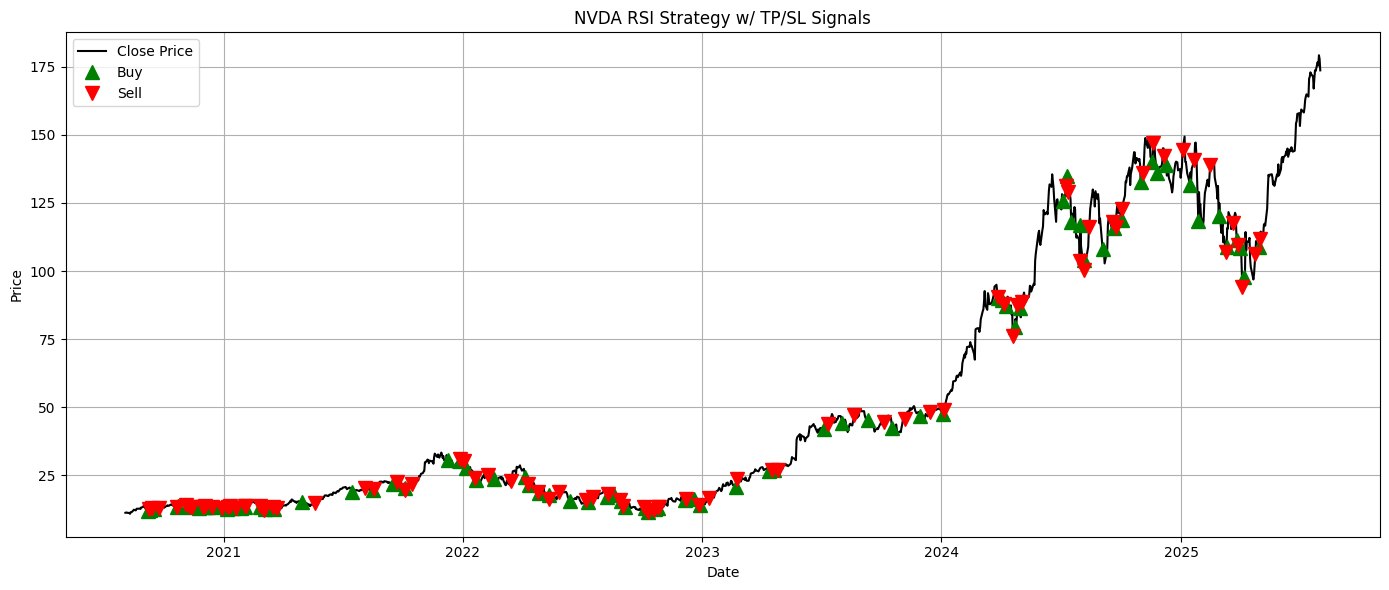

In [265]:
# plotting RSI with Entry and Exit points
plt.figure(figsize=(14,6))
plt.plot(df_rsi_v1['Close'], label = 'Close Price', color = 'black')

buy_signals = df_rsi_v1[df_rsi_v1['TP_SL_Signal'].diff() == 1]
sell_signals = df_rsi_v1[df_rsi_v1['TP_SL_Signal'].diff() == -1]

plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize = 10, color = 'green', label = 'Buy')
plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize = 10, color = 'red', label = 'Sell')
plt.title(f"{ticker} RSI Strategy w/ TP/SL Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()



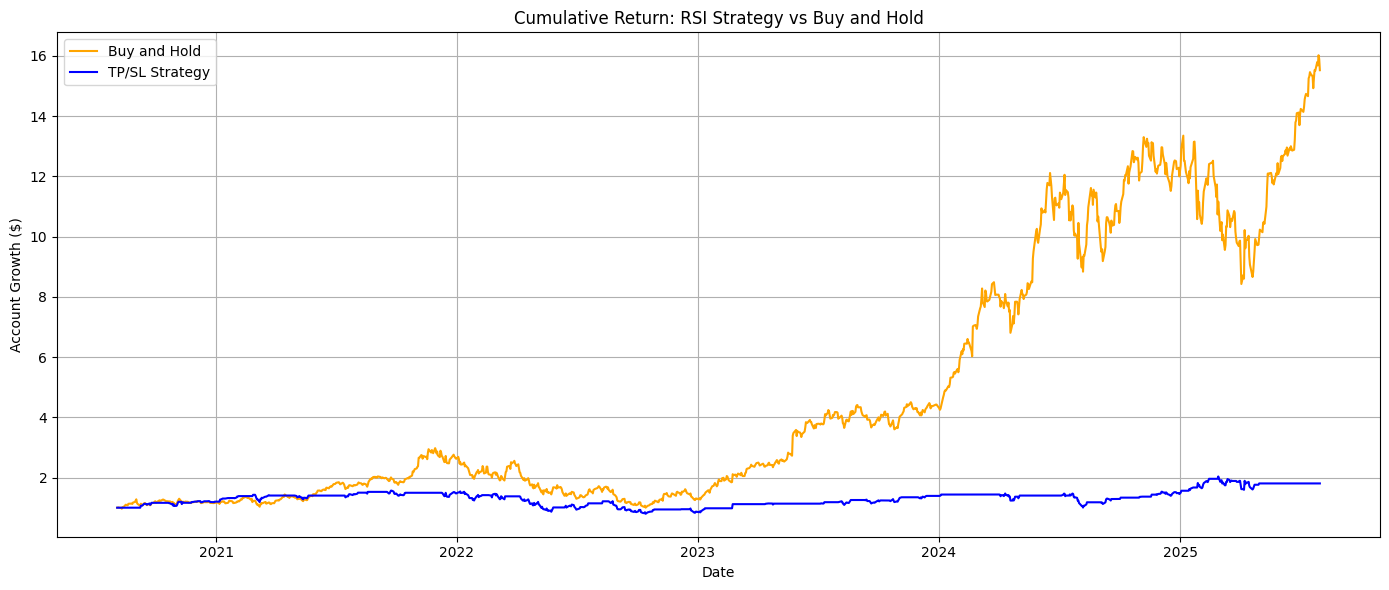

In [266]:
#plot versus simply buying and holding a stock
plt.figure(figsize=(14,6))
plt.plot(df_rsi_v1['Cumulative Market Return'], label = 'Buy and Hold', color = 'orange')
plt.plot(df_rsi_v1['Cumulative Strategy Return'], label = 'TP/SL Strategy', color = 'blue')
plt.title('Cumulative Return: RSI Strategy vs Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Account Growth ($)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


AFTER EXPERIMENTING WITH THE RSI PARAMETERS IT APPEARS THAT WE RARELY REACH 3 DOLLARS LET ALONE 16 DOLLARS THAT THE BUY AND HOLD STRATEGY RETURNED
- PARAMETERS CHANGED
    - LOOSENED RSI OVERBOUGH/SOLD RANGE 
    - INCREASED RSI PERIOD AND DECREASED RSI PERIOD
    - WIDENED TP/SL RANGE 

THIS ALLOWED ME TO COME TO THE REALIZATION THAT PERHAPS WE NEED MORE PARAMETERS OR SIGNALS TO SUPPLY US WITH HIGHER QUALITY ENTRIES

## OUR NEXT IMPLEMENTATIONS WILL BE SIGNALS FOR WHEN RSI CROSSES OVER SPECIFIC VALUES

FEATURES TO IMPLEMENT:
- RSI CROSSOVER SPECIFIC VALUES
- HELPS FILTER OUT NOISE FROM PROLONG OVERSOLD AND OVERBOUGHT PERIODS OF TIME
- ADD FLEXIBILITY TO COMBINE WITH SMA AND EMA STRATEGY


In [267]:
# Strategy Parameters
ticker = "NVDA"
rsi_period = 14
overbought = 60
oversold = 40
take_profit_pct2 = 0.5  # 
stop_loss_pct2 = 0.05    # 
rsi_exit_level = 50

In [268]:
# Date Range
end_date = datetime.today()
start_date = end_date - timedelta(days=365*3)

# Download Data
df_rsi_v2 = yf.download(ticker, start=start_date, end=end_date)
df_rsi_v2 = df_rsi_v2[['Close']].copy()

#Format
df_rsi_v2.columns = df_rsi_v2.columns.get_level_values(0)

C:\Users\nic\AppData\Local\Temp\ipykernel_7304\2606227401.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_rsi_v2 = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [269]:
# Compute RSI --> creating a new column for the RSI Value so we can check it
delta = df_rsi_v2['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window=rsi_period).mean()
avg_loss = loss.rolling(window=rsi_period).mean()
rs = avg_gain / avg_loss
df_rsi_v2['RSI'] = 100 - (100 / (1 + rs))

In [270]:
# RSI CROSS OVER SIGNALS
# Step 1: Identify buy/sell entries
buy_signal = (df_rsi_v2['RSI'].shift(1) < oversold) & (df_rsi_v2['RSI'] >= oversold)
sell_signal = (df_rsi_v2['RSI'].shift(1) > overbought) & (df_rsi_v2['RSI'] <= overbought)

# Step 2: Initialize Signal column
df_rsi_v2['Signal'] = 0
df_rsi_v2.loc[buy_signal, 'Signal'] = 1   # Long entry
df_rsi_v2.loc[sell_signal, 'Signal'] = -1  # Short entry

In [271]:
# take profit and stop loss logic
# includes long and short trade logic
rsi_exit_count = 0
tp_exit_count = 0
sl_exit_count = 0


tp_sl_signals = []
in_trade = False
entry_price = 0
position_type = 0  # 1 = long, -1 = short

for i in range(len(df_rsi_v2)):
    price = df_rsi_v2['Close'].iloc[i]
    rsi = df_rsi_v2['RSI'].iloc[i]
    signal = df_rsi_v2['Signal'].iloc[i]

    if not in_trade:
        if signal == 1:  # Long entry
            in_trade = True
            entry_price = price
            position_type = 1
            tp_sl_signals.append(position_type)
        elif signal == -1:  # Short entry
            in_trade = True
            entry_price = price
            position_type = -1
            tp_sl_signals.append(position_type)
        else:
            tp_sl_signals.append(0)
    else:
        # Long trade
        if position_type == 1:
            current_return = (price - entry_price) / entry_price
            rsi_exit = rsi > rsi_exit_level
        # Short trade
        else:
            current_return = (entry_price - price) / entry_price
            rsi_exit = rsi < rsi_exit_level

        if current_return >= take_profit_pct2:
            tp_exit_count += 1
        elif current_return <= -stop_loss_pct2:
            sl_exit_count += 1
        elif rsi_exit:
            rsi_exit_count += 1

        if current_return >= take_profit_pct2 or current_return <= -stop_loss_pct2 or rsi_exit:
            in_trade = False
            position_type = 0
            tp_sl_signals.append(0)
        else:
            tp_sl_signals.append(position_type)

# Final signal logic
df_rsi_v2['TP_SL_Signal'] = tp_sl_signals



In [272]:
print(f"Exited by TP: {tp_exit_count}")
print(f"Exited by SL: {sl_exit_count}")
print(f"Exited by RSI: {rsi_exit_count}")


Exited by TP: 0
Exited by SL: 15
Exited by RSI: 37


In [273]:
# Calculate Returns
df_rsi_v2['Market Return'] = df_rsi_v2['Close'].pct_change()
df_rsi_v2['Strategy Return'] = df_rsi_v2['Market Return'] * df_rsi_v2['TP_SL_Signal'].shift(1).fillna(0)
df_rsi_v2['Cumulative Market Return'] = (1 + df_rsi_v2['Market Return'].fillna(0)).cumprod()
df_rsi_v2['Cumulative Strategy Return'] = (1 + df_rsi_v2['Strategy Return']).cumprod()

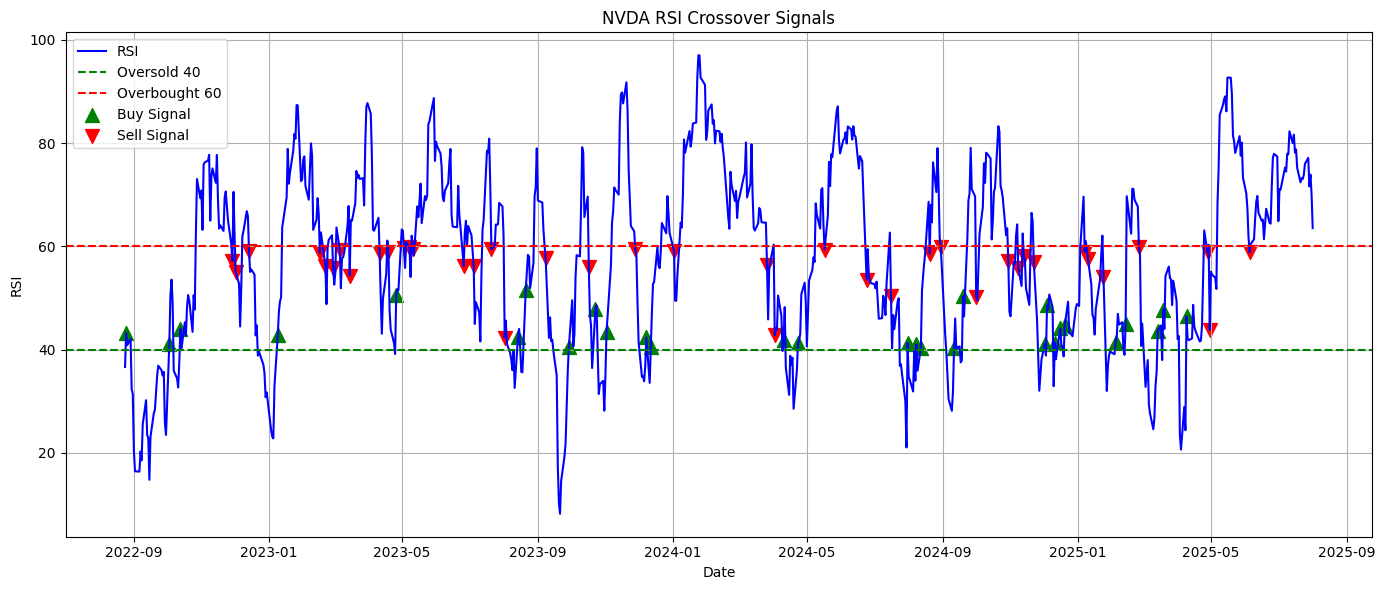

In [274]:
# Plot RSI with Signals
plt.figure(figsize=(14, 6))
plt.plot(df_rsi_v2['RSI'], label='RSI', color='blue')
plt.axhline(oversold, color='green', linestyle = '--', label=f'Oversold {oversold}')
plt.axhline(overbought, color='red', linestyle = '--', label=f'Overbought {overbought}')

plt.scatter(df_rsi_v2[df_rsi_v2['Signal'] == 1].index, 
            df_rsi_v2['RSI'][df_rsi_v2['Signal'] == 1],
            marker='^', color='green', label='Buy Signal', s=100)

plt.scatter(df_rsi_v2[df_rsi_v2['Signal'] == -1].index, 
            df_rsi_v2['RSI'][df_rsi_v2['Signal'] == -1],
            marker='v', color='red', label='Sell Signal', s=100)

plt.title(f"{ticker} RSI Crossover Signals")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

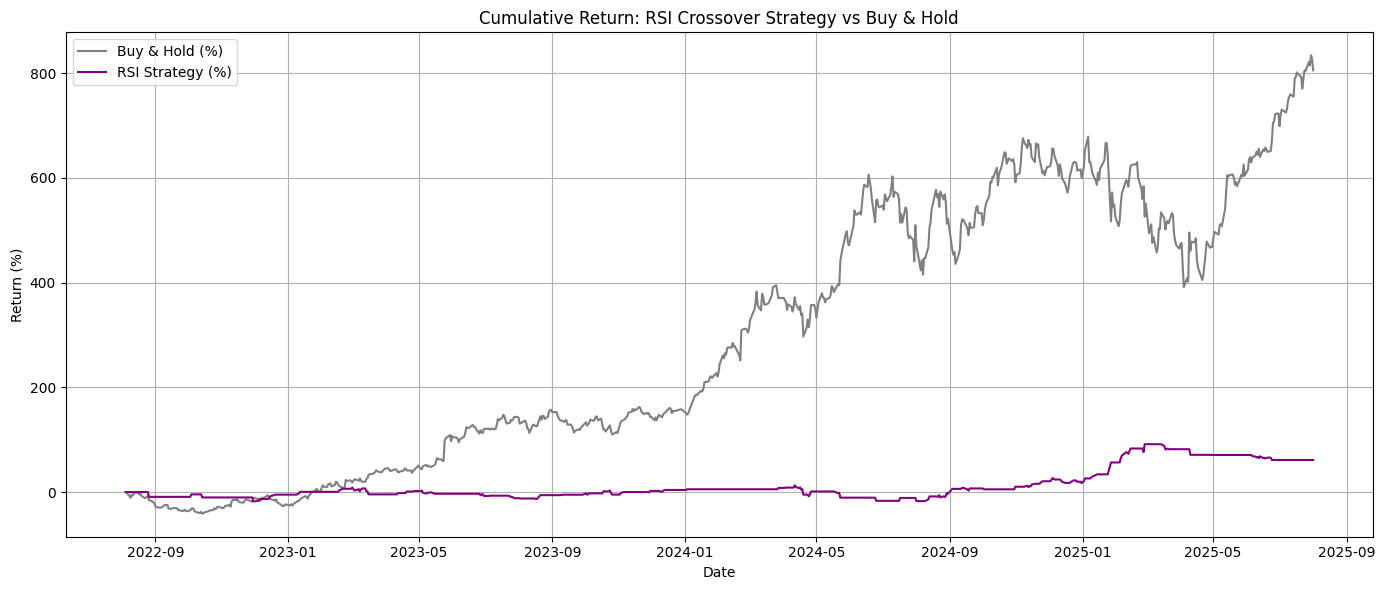

In [275]:
# Strategy versus Market Returns

plt.figure(figsize=(14, 6))
plt.plot((df_rsi_v2['Cumulative Market Return'] - 1) * 100, label='Buy & Hold (%)', color='gray')
plt.plot((df_rsi_v2['Cumulative Strategy Return'] - 1) * 100, label='RSI Strategy (%)', color='purple')
plt.title("Cumulative Return: RSI Crossover Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [276]:
df_rsi_v2['Signal'].value_counts()

Signal
 0    682
-1     40
 1     29
Name: count, dtype: int64

UPON ANALYSIS OF THE RSI STRATEGY IT APPEARS THAT WHEN NVIDIA WAS ON A VERY STRONG UPWARD TREND, RSI SIGNALS TO USE THAT "HEY SHORT OR SELL THIS BECAUSE IT IS OVERBOUGHT" WHEN IN REALITY ITS JUST A STRONG BULL RUN

RSI COULD WORK BETTER IN STOCKS THAT HAVE A NORMAL RANGE OF PRICES OR APPEARS TO GO SIDEWAYS AS THEN THE PRICE IS MORE LIKELY TO RETURN TO THE MIDDLE. 

HOW COULD RSI PERFORM IN A VOLATILE AND CHOPPY STOCK MARKET?


In [277]:
tp_values = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
results_rsi = []

for tp in tp_values:
    df = df_rsi_v2.copy()
    signals = []
    in_trade = False
    entry_price = 0
    trade_returns = []

    for i in range(len(df)):
        close = df['Close'].iloc[i]
        rsi = df['RSI'].iloc[i]

        if not in_trade:
            if rsi < rsi_oversold:
                print(f"Entering trade at index {i} with RSI: {rsi:.2f}, Close: {close}")
                entry_price = close
                in_trade = True
                signals.append(1)
            else:
                signals.append(0)
        else:
            ret = (close - entry_price) / entry_price
            exit_signal = False#rsi > rsi_overbought

            if ret >= tp or ret <= -stop_loss_pct or exit_signal:
                trade_returns.append(ret)
                in_trade = False
                signals.append(0)
            else:
                signals.append(1)

    df['TP_SL_Signal'] = signals
    df['Market Return'] = df['Close'].pct_change()
    df['Strategy Return'] = df['Market Return'] * df['TP_SL_Signal'].shift(1).fillna(0)
    df['Cumulative Strategy Return'] = (1 + df['Strategy Return'].fillna(0)).cumprod()

    if in_trade:
        final_close = df['Close'].iloc[-1]
        final_ret = (final_close - entry_price) / entry_price
        trade_returns.append(final_ret)


    trade_returns = pd.Series(trade_returns)
    total_trades = len(trade_returns)
    win_rate = (trade_returns > 0).sum() / total_trades if total_trades else 0
    avg_win = trade_returns[trade_returns > 0].mean() if total_trades else 0
    avg_loss = trade_returns[trade_returns < 0].mean() if total_trades else 0
    profit_factor = abs(trade_returns[trade_returns > 0].sum() / trade_returns[trade_returns < 0].sum()) if (trade_returns < 0).sum() != 0 else None
    final_return = df['Cumulative Strategy Return'].iloc[-1]

    results_rsi.append({
        'TP (%)': int(tp * 100),
        'Total Trades': total_trades,
        'Win Rate (%)': round(win_rate * 100, 2),
        'Avg Win (%)': round(avg_win * 100, 2),
        'Avg Loss (%)': round(avg_loss * 100, 2),
        'Profit Factor': round(profit_factor, 2) if profit_factor else None,
        'Final Return (x)': round(final_return, 2)
    })

    print(f"TP {tp:.2f} → {len(trade_returns)} trades")


results_rsi_df = pd.DataFrame(results_rsi)
display(results_rsi_df)


Entering trade at index 14 with RSI: 36.62, Close: 17.197195053100586
Entering trade at index 19 with RSI: 31.41, Close: 15.072257995605469
Entering trade at index 23 with RSI: 20.24, Close: 13.698314666748047
Entering trade at index 27 with RSI: 23.38, Close: 13.115983009338379
Entering trade at index 47 with RSI: 32.66, Close: 11.572749137878418
Entering trade at index 98 with RSI: 38.82, Close: 15.325377464294434
Entering trade at index 181 with RSI: 39.13, Close: 26.222150802612305
Entering trade at index 252 with RSI: 39.30, Close: 45.38906478881836
Entering trade at index 260 with RSI: 35.66, Close: 43.31734085083008
Entering trade at index 280 with RSI: 39.72, Close: 43.87661361694336
Entering trade at index 305 with RSI: 36.42, Close: 41.364952087402344
Entering trade at index 308 with RSI: 39.77, Close: 41.756744384765625
Entering trade at index 335 with RSI: 34.69, Close: 45.485755920410156
Entering trade at index 421 with RSI: 39.73, Close: 85.32002258300781
Entering trade a

,TP (%),Total Trades,Win Rate (%),Avg Win (%),Avg Loss (%),Profit Factor,Final Return (x)
0,5,28,78.57,7.41,-11.30,2.40,2.34
1,10,20,55.00,11.64,-11.33,1.26,1.13
2,15,18,50.00,16.66,-11.33,1.47,1.35
3,20,17,47.06,23.75,-11.33,1.86,1.86
4,25,16,43.75,30.09,-11.33,2.07,2.12
5,30,16,43.75,33.22,-11.33,2.28,2.51
6,35,16,43.75,39.11,-11.33,2.69,3.41
7,40,16,43.75,42.67,-11.33,2.93,4.07
8,45,12,50.00,46.60,-10.78,4.32,5.01
9,50,11,45.45,53.11,-10.78,4.11,4.24
